Resources

https://opensourcefootball.com/posts/2020-09-28-nflfastr-ep-wp-and-cp-models/



In [2]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from scipy import stats
pd.set_option('display.max_columns', None)  # Ensure all columns are shown
pd.set_option('display.width', 1000)  # Adjust width to prevent wrapping (tweak this number based on your display)

In [3]:
data = nfl.import_pbp_data(years=[2023, 2022, 2021, 2020, 2019,2018])

2023 done.
2022 done.
2021 done.
2020 done.
2019 done.
2018 done.
Downcasting floats.


In [4]:
data.shape

(291096, 390)

In [5]:
data['game_date'] = pd.to_datetime(data['game_date'])
data['year'] = data['game_date'].dt.year

/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_24751/597303287.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['year'] = data['game_date'].dt.year


In [6]:
data['year'].value_counts()

2023    52140
2022    49852
2019    47328
2021    47205
2018    45120
2020    44545
2024     4906
Name: year, dtype: int64

In [7]:
cols_to_keep = [
    'home_team', # which team is the home team
    'year', 
    'season_type', # Reg or postseason game
    'week', # What week in the regular season
    'posteam', # team that has possession
    'posteam_type', # whether they are home or away
    'defteam', # defending team
    'yardline_100', # how many yards away from endzone are we?
    'quarter_seconds_remaining', # seconds left in the quarter
    'half_seconds_remaining',
    'game_seconds_remaining', # seconds left in game
   # 'game_half', # half1, half2, or overtime
    'drive' , # the drive number of the game
    'down' , # I only want to look at 4th down plays
    'goal_to_go', # binary: is it a goal to go situation
    'ydstogo' , # this could be the most important feature
    'ydsnet', # length of the drive to this point
    
    'play_type', # pass, run, no_play, kickoff, punt, xp, fg, qb kneel, qb spike
#   'run_location', # this will not be used to predict.
#   'pass_location', 
#   'pass_length',
    
    'no_huddle', # binary
    'posteam_timeouts_remaining',
    'defteam_timeouts_remaining',
    'posteam_score',
    'defteam_score',
    'score_differential',
    
    # probabilities of opponents scoring
    'no_score_prob', # Predicted probability of no score occurring for the rest of the half based on the expected points model.
    'opp_fg_prob', # for next drive
    'opp_td_prob', 
    
    # probabilities of possessing team scoring
    'fg_prob', # fg for this drive
    'td_prob',
    
    'ep', # expected points for play
    # 'epa', # expected points added as a result of play (cant use)
    
    'wp', # win probability at start of play
    'vegas_wp',
    'wpa', # win probability added
    'vegas_wpa', # vegas's wpa
    
    # 'sack', # was the play a sack
    
    
    'fixed_drive', # driver number
    'drive_play_count',
    # 'drive_time_of_possession',
    
    'spread_line', # The closing spread line for the game. A positive number means the home team was favored by that many points, a negative number means the away team was favored by that many points

#     'temp', # temperature at stadium
#     'wind', # wind speed
    
#     'passer', #name of qb
#     'rusher', # name of rb
#     'receiver', # name of receiver
    
    'total_home_epa',
    'total_away_epa', 
    'total_home_rush_epa',
    'total_away_rush_epa',
    'total_home_pass_epa',
    'total_away_pass_epa',
    
]

df = data[cols_to_keep]
fourth_down = df[df['down'] == 4]

In [8]:
def align_spread(row): # adjust the spread so it aligns with the team with the ball instead of the home team
    if row["posteam_is_home"] is False:
        return row['spread_line'] * -1
    else:
        return row['spread_line']
    
def align_total_epa(row):
    if row['posteam_is_home'] is True:
        return row['total_home_epa']
    else:
        return row['total_away_epa']
    
def align_rush_epa(row):
    if row['posteam_is_home'] is True:
        return row['total_home_rush_epa']
    else:
        return row['total_away_rush_epa']
    
def align_pass_epa(row):
    if row['posteam_is_home'] is True:
        return row['total_home_pass_epa']
    else:
        return row['total_away_pass_epa']
        
fourth_down['posteam_is_home'] = fourth_down.apply(lambda row: row['posteam'] == row['home_team'], axis=1)
fourth_down['posteam_spread_line'] = fourth_down.apply(align_spread, axis=1)
fourth_down['wpa_avg'] = (fourth_down['wpa'] + fourth_down['vegas_wpa']) / 2
fourth_down['wp_avg'] = fourth_down.apply(lambda row: (row['wp'] + row["vegas_wp"]) / 2, axis=1)
fourth_down['is_reg_season'] = fourth_down['season_type'].apply(lambda x: True if x == "REG" else False)
fourth_down['wpa_difference'] = abs(fourth_down['wpa'] - fourth_down['vegas_wpa'])
fourth_down['wp_difference'] = abs(fourth_down['wp'] - fourth_down['vegas_wp'])


fourth_down['posteam_total_epa'] = fourth_down.apply(align_total_epa, axis=1)
fourth_down['posteam_total_rush_epa'] = fourth_down.apply(align_rush_epa, axis=1)
fourth_down['posteam_total_pass_epa'] = fourth_down.apply(align_total_epa, axis=1)


fourth_down['posteam_epa_per_sec'] = fourth_down.apply(lambda row: row['posteam_total_epa'] / (3600 - row['game_seconds_remaining']), axis=1)
fourth_down['posteam_rush_epa_per_sec'] = fourth_down.apply(lambda row: row['posteam_total_rush_epa'] / (3600 - row['game_seconds_remaining']), axis=1)
fourth_down['posteam_pass_epa_per_sec'] = fourth_down.apply(lambda row: row['posteam_total_pass_epa'] / (3600 - row['game_seconds_remaining']), axis=1)

fourth_down.drop(columns=[
                'season_type',  
                 'total_home_epa',
                 'total_away_epa', 
                 'total_home_rush_epa',
                 'total_away_rush_epa',
                 'total_home_pass_epa',
                 'total_away_pass_epa',
                 'wp',
                 'vegas_wp',
                 'home_team',
                 'defteam',
                 'down',
                 'posteam_score',
                 'defteam_score',
                 'posteam',
                 'posteam_type',
                 'wpa',
                 'vegas_wpa',
                 'wpa_difference',        
                 'fixed_drive',
                 'quarter_seconds_remaining', 
                 'goal_to_go', 
                 'opp_td_prob', 
                 'opp_fg_prob',
                 'posteam_total_epa',
                 'posteam_total_rush_epa',
                 'posteam_total_pass_epa',
                 'posteam_epa_per_sec',
 
                  ], inplace=True)
print(fourth_down.shape)
fourth_down.to_csv('fourth_down_dataset.csv', index=False)


/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_24751/4261309194.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourth_down['posteam_is_home'] = fourth_down.apply(lambda row: row['posteam'] == row['home_team'], axis=1)
/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_24751/4261309194.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourth_down['posteam_spread_line'] = fourth_down.apply(align_spread, axis=1)
/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_24751/42613

(24895, 27)


In [9]:
fourth_down.corr()

/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_24751/1434531262.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  fourth_down.corr()


,year,week,yardline_100,half_seconds_remaining,game_seconds_remaining,drive,ydstogo,ydsnet,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,no_score_prob,fg_prob,td_prob,ep,drive_play_count,spread_line,posteam_is_home,posteam_spread_line,wpa_avg,wp_avg,is_reg_season,wp_difference,posteam_rush_epa_per_sec,posteam_pass_epa_per_sec
year,1.000000,0.123806,-0.009276,-0.002120,-0.002000,-0.014373,-0.024170,0.012225,0.040023,0.036801,0.037350,0.000065,-0.004144,0.008511,0.004582,0.012698,0.024703,-0.011078,0.002448,-0.006007,0.029320,-0.001384,-0.103319,-0.030444,0.007111,0.021708
week,0.123806,1.000000,-0.001557,-0.002897,-0.006214,-0.005663,-0.012524,0.001843,-0.000732,0.021045,0.026775,-0.004665,-0.003461,-0.005522,0.015172,0.000898,0.011445,0.027426,-0.001052,-0.004829,0.000759,-0.006936,-0.375912,0.042691,-0.001218,0.002617
yardline_100,-0.009276,-0.001557,1.000000,0.126469,0.085476,-0.024726,0.250255,-0.749967,-0.035896,0.106373,0.074933,-0.022546,0.223299,-0.848303,0.278107,-0.961397,-0.680766,0.004575,-0.004123,-0.063275,0.022013,-0.153229,0.002461,0.013360,-0.099087,-0.233884
half_seconds_remaining,-0.002120,-0.002897,0.126469,1.000000,0.517358,-0.447312,-0.012868,-0.112588,-0.044272,0.504757,0.526717,0.000608,-0.683370,-0.039700,0.426839,-0.197698,-0.137382,0.003711,-0.003365,-0.010432,0.013848,-0.032524,0.000393,0.262644,-0.083898,-0.159564
game_seconds_remaining,-0.002000,-0.006214,0.085476,0.517358,1.000000,-0.943368,-0.019781,-0.077533,-0.064853,0.304407,0.349719,-0.007940,-0.359669,-0.021174,0.212723,-0.114928,-0.109432,0.004157,-0.005818,-0.015790,0.018767,-0.043033,0.003981,0.534462,-0.099465,-0.186103
drive,-0.014373,-0.005663,-0.024726,-0.447312,-0.943368,1.000000,0.023052,0.004395,0.059861,-0.281527,-0.324342,0.009324,0.341615,-0.029379,-0.175587,0.052623,0.026370,0.002287,0.006542,0.016132,-0.005851,0.036341,0.005387,-0.522763,0.088531,0.162681
ydstogo,-0.024170,-0.012524,0.250255,-0.012868,-0.019781,0.023052,1.000000,-0.311527,-0.085578,0.017256,-0.006850,-0.047479,0.068764,-0.131102,-0.192200,-0.318189,-0.132833,-0.015724,0.000779,-0.037453,0.063010,-0.105357,0.005627,-0.019843,-0.008647,-0.073068
ydsnet,0.012225,0.001843,-0.749967,-0.112588,-0.077533,0.004395,-0.311527,1.000000,0.093904,-0.094432,-0.026586,-0.092047,-0.161485,0.622878,-0.153128,0.749929,0.858083,-0.003047,-0.004264,0.033317,0.077097,0.002803,-0.007359,-0.018643,0.090572,0.158391
no_huddle,0.040023,-0.000732,-0.035896,-0.044272,-0.064853,0.059861,-0.085578,0.093904,1.000000,-0.054079,-0.006165,-0.082870,0.056807,-0.021052,0.064980,0.063092,0.102369,-0.002807,0.020447,-0.013403,0.003593,-0.079636,0.001207,-0.045816,-0.011440,-0.008551
posteam_timeouts_remaining,0.036801,0.021045,0.106373,0.504757,0.304407,-0.281527,0.017256,-0.094432,-0.054079,1.000000,0.392688,-0.024371,-0.486510,-0.036751,0.296816,-0.157028,-0.103557,-0.011267,0.016221,0.001028,-0.021390,-0.020467,0.004279,0.153435,-0.049349,-0.086841


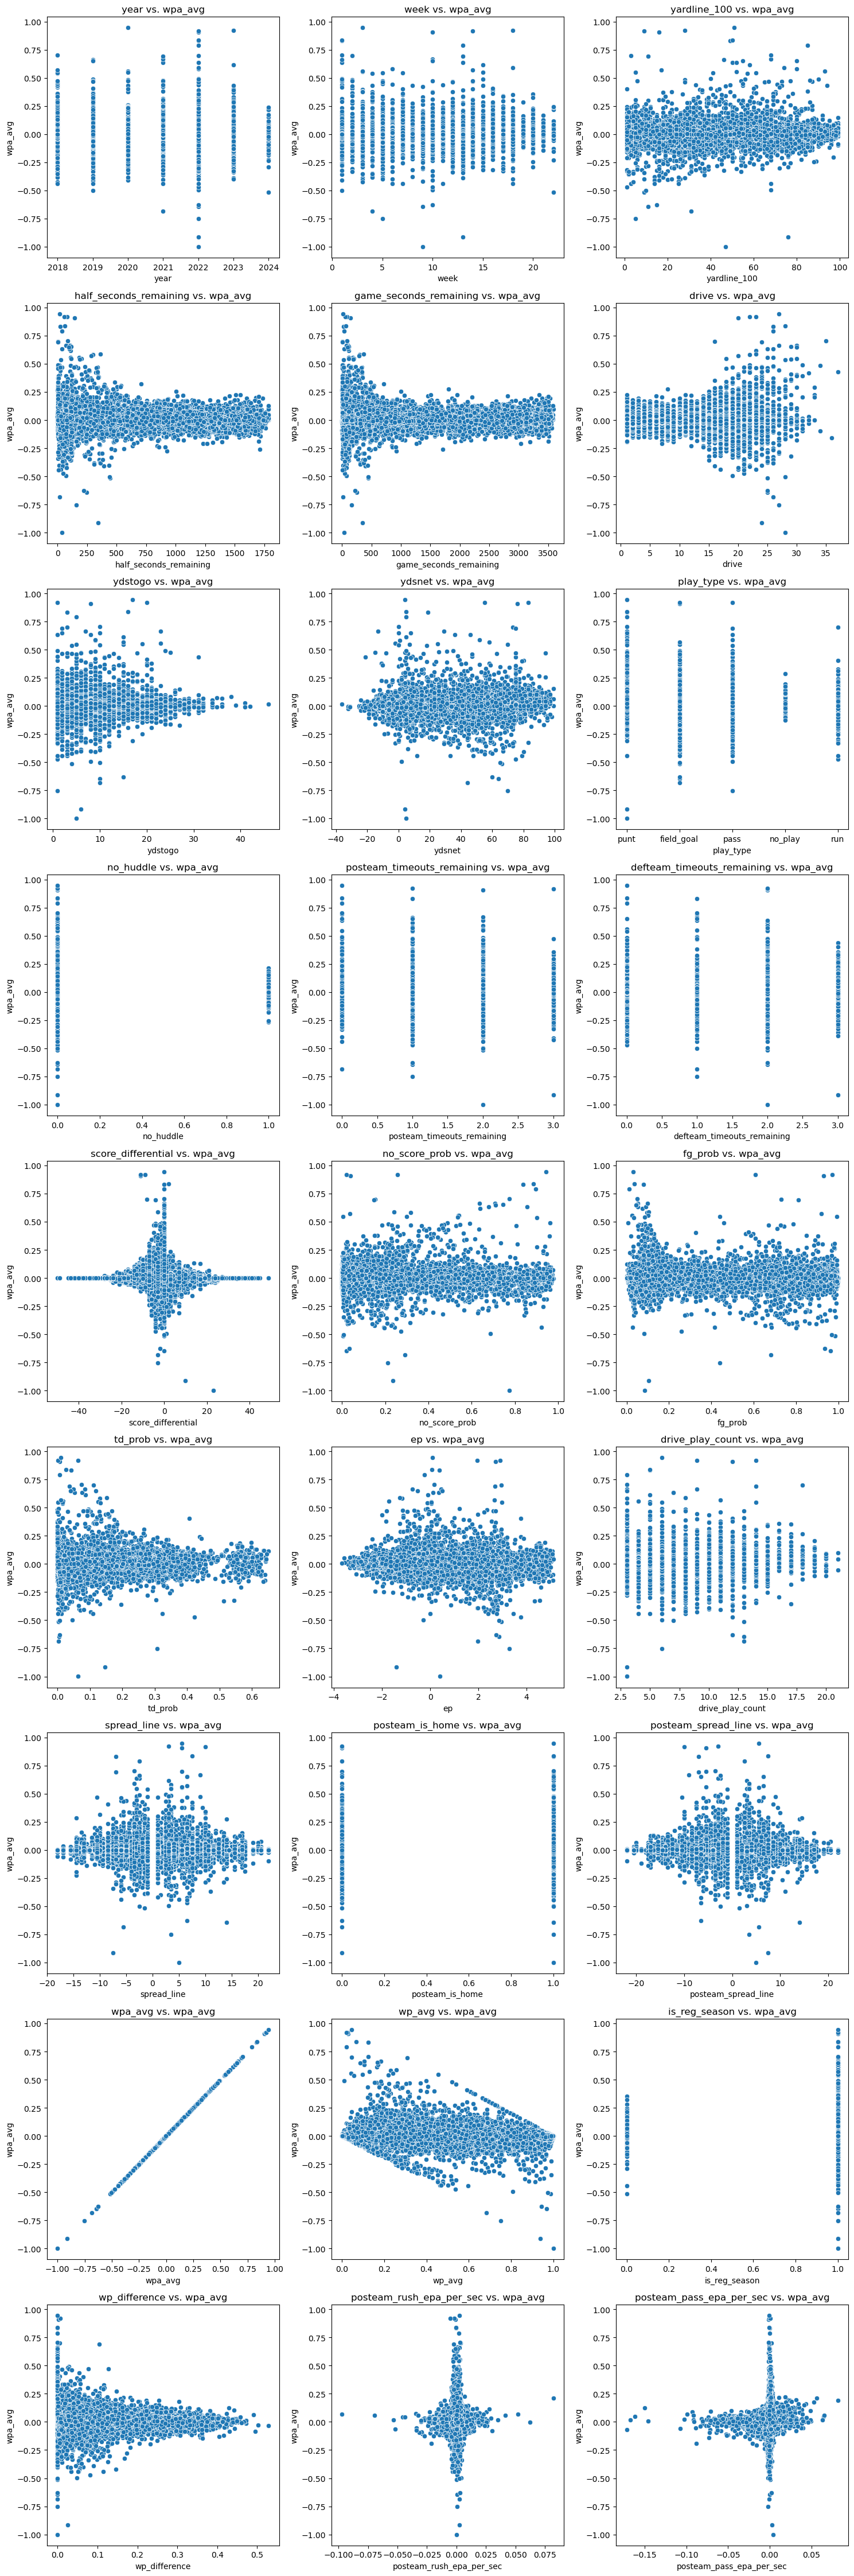

In [10]:
cols = fourth_down.columns
num_cols = 3

num_rows = (len(cols) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, var in enumerate(cols):
    row_index, col_index = divmod(i, num_cols)
    ax = axes[row_index, col_index]
    sns.scatterplot(data=fourth_down, x=var, y='wpa_avg', ax=ax)
    ax.set_title(f'{var} vs. wpa_avg')

for i in range(len(cols), num_rows * num_cols):
    row_index, col_index = divmod(i, num_cols)
    fig.delaxes(axes[row_index, col_index])

plt.tight_layout()
plt.savefig('features_vs_wpa.png')
plt.show()

In [13]:
for col in fourth_down.columns:
    print(col, fourth_down[col].dtype)

year int64
week int32
yardline_100 float32
half_seconds_remaining float32
game_seconds_remaining float32
drive float32
ydstogo float32
ydsnet float32
play_type object
no_huddle float32
posteam_timeouts_remaining float32
defteam_timeouts_remaining float32
score_differential float32
no_score_prob float32
fg_prob float32
td_prob float32
ep float32
drive_play_count float32
spread_line float32
posteam_is_home bool
posteam_spread_line float64
wpa_avg float32
wp_avg float64
is_reg_season bool
wp_difference float32
posteam_rush_epa_per_sec float64
posteam_pass_epa_per_sec float64


/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_43233/34328235.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = fourth_down.corr()


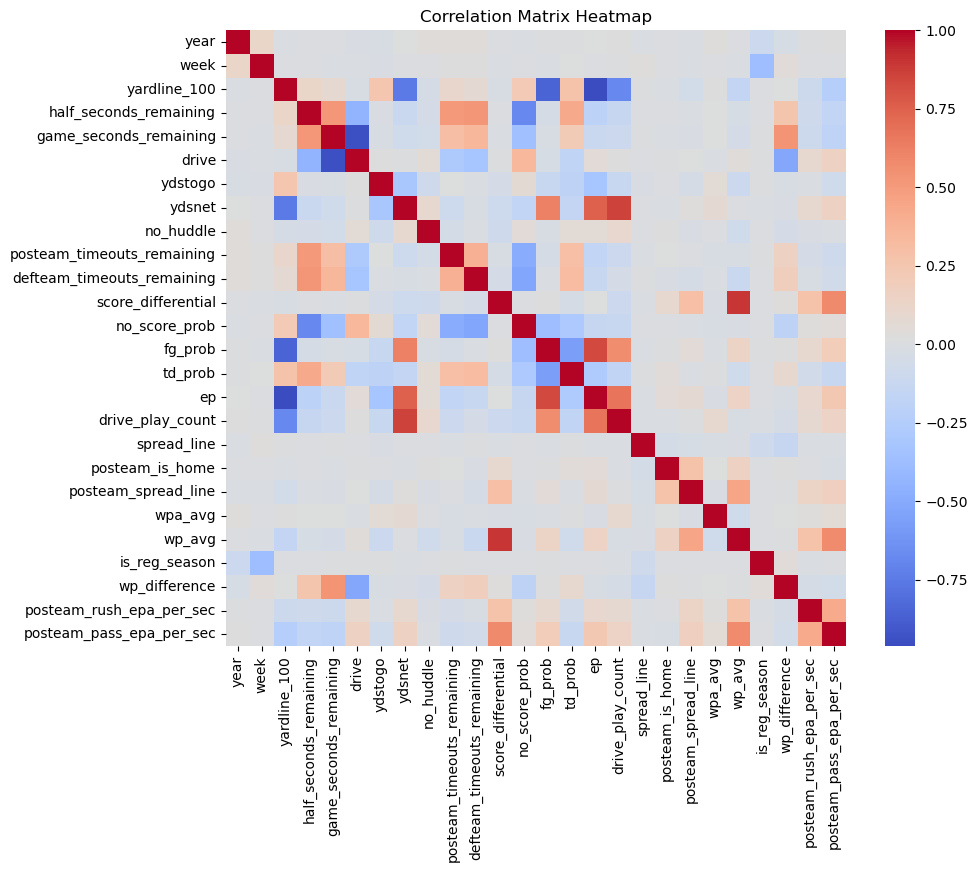

In [14]:
correlation_matrix = fourth_down.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [50]:
'''
Groups of Correlated Variables:

Win Probability Vars:
wp_avg, score_differential, posteam_spread_line, all total epa and epa per sec

Time Left in Game Vars:
Fixed_drive, drive, half seconds, quarter seconds, timeouts remaining

Ep:
ep, yardline_100 , goal to go, opp td prob, opp fg prob, fg prob, td prob

yardline_100/length of drive:
drive play count , td prob, fg prob , ydsnet, goal to go


Remove:
score differential,spread line,

fixed_drive,drive, 
half_seconds_remaining, 
quarter_seconds_remaining, 
goaltogo, opp_td_prob, 
opp_fg_prob,
posteam_total_epa,
posteam_total_rush_epa,
posteam_total_pass_epa,
posteam_epa_per_sec,

'''

'\nGroups of Correlated Variables:\n\nWin Probability Vars:\nwp_avg, score_differential, posteam_spread_line, \n'

In [22]:
def partition(data, play_type="pass"):
    return data[data['play_type'] == play_type].drop('play_type', axis=1)

passing = partition(fourth_down,'pass')
run = partition(fourth_down,'run')
fg = partition(fourth_down,'field_goal')
punt = partition(fourth_down,'punt')

In [23]:
y = run['wpa_avg'].to_numpy()
X = run.drop('wpa_avg', axis=1)
cols = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
selected_feat = X_train.columns[(sel.get_support())]

Index(['game_seconds_remaining', 'drive', 'score_differential', 'drive_play_count', 'wp_avg', 'wp_difference', 'posteam_rush_epa_per_sec', 'posteam_pass_epa_per_sec'], dtype='object')

In [ ]:
'''
median:
Index(['game_seconds_remaining', 
'drive', 'score_differential', 
'drive_play_count', 'wp_avg', 
'wp_difference', 'posteam_rush_epa_per_sec', 
'posteam_pass_epa_per_sec'], dtype='object')


mean:

'''

In [31]:
a = np.array([1,2,3,2,2,2,2,1,1,1])
np.where(a == 2)[0]

array([1, 3, 4, 5, 6])